In [7]:
import cv2
import numpy as np
from scipy import ndimage
import requests
from pathlib import Path


# visual 
import matplotlib.pyplot as plt

In [3]:
def view_image(window_name,img,destroy=False):
    cv2.namedWindow(window_name,cv2.WINDOW_NORMAL)
    cv2.imshow(window_name,img)
    if destroy:
        cv2.waitKey()
        cv2.destroyAllWindows()

In [4]:
def plot_img(img,rgb=True,figsize=(4,3)):
    plt.figure(figsize=figsize)
    if rgb:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    plt.axis("off")

In [85]:
def download_image(url,filename):
    res = requests.get(url,stream=True)
    if res.status_code == 200:
        path = "../images/"+ filename+".jpg"
        print(f"[INFO] downloading image and saving to {path}")
        with open(path,"wb") as f:
            for chunk in res.iter_content(chunk_size=1024):
                f.write(chunk)
    else:
        print(f"[INFO] Failed download image")

# High Pass Filter and Low Pass Filter

In [5]:
response = requests.get("https://raw.githubusercontent.com/PacktPublishing/Learning-OpenCV-4-Computer-Vision-with-Python-Third-Edition/master/images/statue_small.jpg",
                        stream=True)
if response.status_code == 200:
    with open("../images/statue.jpg",'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)

In [3]:
kernel_3x3  = np.full(shape=(3,3),fill_value=-1)
kernel_3x3[1,1] = 8
kernel_3x3

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

In [4]:
kernel_5x5 = np.full(shape=(5,5),fill_value=-1)
kernel_5x5[1:4,1:4] = np.array([[1,2,1],
                                [2,4,2],
                                [1,2,1]])
kernel_5x5

array([[-1, -1, -1, -1, -1],
       [-1,  1,  2,  1, -1],
       [-1,  2,  4,  2, -1],
       [-1,  1,  2,  1, -1],
       [-1, -1, -1, -1, -1]])

In [6]:
img = cv2.imread("../images/statue.jpg",cv2.IMREAD_GRAYSCALE)
k3 = ndimage.convolve(img,kernel_3x3)
k5 = ndimage.convolve(img,kernel_5x5)

blurred = cv2.GaussianBlur(img,(17,17),11)
g_hpf = img - blurred

view_image("3x3",k3)
view_image("5x5",k5)
view_image("blurred",blurred)
view_image("g_hpf",g_hpf)
cv2.waitKey()
cv2.destroyAllWindows()

# Edge Detection

1. OpenCV provides many edge-finding filters including 
   1. Laplacian
   2. Sobel
   3. Scharr
2. These filter turn non0edge region into black and turn the edge region into white.
3. However these filter are prone to capture the noise as edge.
4. To overcome the drawback we will blur to image to denoise  the image.

In [28]:
def stroke_edge(src,dst,blur_ksize = 7, edge_ksize = 5 ):
    view_image("source",src)
    # apply blur image
    if blur_ksize >= 3:
        blurred_src = cv2.medianBlur(src,blur_ksize)
        view_image("blur",blurred_src)
        gray_src = cv2.cvtColor(blurred_src,code=cv2.COLOR_BGR2GRAY)
    else:
        gray_src = cv2.cvtColor(src,code=cv2.COLOR_BGR2GRAY)
    view_image("gray",gray_src)
    # apply edge detector
    cv2.Laplacian(gray_src,cv2.CV_8U,gray_src,edge_ksize)
    view_image("Laplacian",gray_src)
    normalized_inverse_alpha = (1.0/255) * (255 - gray_src)
    channels = cv2.split(src)
    for channel  in channels:
        channel[:] = channel * normalized_inverse_alpha
    cv2.merge(channels,dst)   
    
    view_image("final",dst)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [29]:
img = cv2.imread("../images/statue.jpg")

In [30]:
stroke_edge(img,img)

In [36]:
view_image("sfd",img)
cv2.waitKey()
cv2.destroyAllWindows()

# Custom Kernel

## Sharpen kernel

When the weight kernel sum to 1. then we have the sharpen kernel.

In [59]:
# central element in the kernel matrix is pixel of interest
sharp_kernel = np.full(shape=(3,3),fill_value=-1)
sharp_kernel[1,1] = 9
sharp_kernel
#? if the pixel of interest is already different from its neighbor ,
#?  then this difference is intensified

array([[-1, -1, -1],
       [-1,  9, -1],
       [-1, -1, -1]])

In [60]:
np.sum(sharp_kernel)

1

In [61]:
modified_sharpen_kernel = np.full(shape=(3,3),fill_value=-2)
modified_sharpen_kernel[1,1] = 17
modified_sharpen_kernel

array([[-2, -2, -2],
       [-2, 17, -2],
       [-2, -2, -2]])

In [70]:
img = cv2.imread("../images/statue.jpg")

In [71]:
view_image("Sharpen",cv2.filter2D(img,-1,sharp_kernel))
view_image("modified_sharpen_kernel",cv2.filter2D(img,-1,modified_sharpen_kernel))
cv2.waitKey()
cv2.destroyAllWindows()

## Edge Filter

In [72]:
edge_kernel = np.full(shape=(3,3),fill_value=-1)
edge_kernel[1,1] = 8
edge_kernel

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

In [74]:
view_image("original",img)
view_image("Sharpen",cv2.filter2D(img,-1,edge_kernel))
cv2.waitKey()
cv2.destroyAllWindows()

## Blur Filter

In [45]:
blur_kernel = np.full(shape=(5,5),fill_value=0.04)
blur_kernel

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

In [51]:
view_image("Blur",cv2.filter2D(img,-1,blur_kernel),destroy=True)

## Emboss Filter

In [52]:
emboss_kernel = np.array([[-2,-1,0],
                          [-1,1,1],
                          [0,1,2]])
emboss_kernel

array([[-2, -1,  0],
       [-1,  1,  1],
       [ 0,  1,  2]])

In [53]:
view_image("emboss",cv2.filter2D(img,-1,emboss_kernel),destroy=True)

## Canny Edge detection

In [85]:
view_image("original",img)
view_image("Canny",cv2.Canny(img,200,300))
cv2.waitKey()
cv2.destroyAllWindows()

# Contour detection

Find the region of interests

In [107]:
#create the black image
img = np.zeros((200,200),dtype=np.uint8)
view_image("black",img)

# place the white square in the center
img[50:150,50:150] = 255
view_image("center white",img)

# binary threshold
_,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
view_image("thresh",thresh)

contours, hierarchy = cv2.findContours(thresh,
                                       mode=cv2.RETR_TREE , #  how return the contour 
                                       method=cv2.CHAIN_APPROX_SIMPLE # tell the return the boundary
                                     )

# draw the contour
color = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
img = cv2.drawContours(image=color,
                       contours=contours,
                       contourIdx=-1,# draw all the contour
                       color= (0,255,0) , # green color
                       thickness=3
                       )
view_image("contours",img)
cv2.waitKey()
cv2.destroyAllWindows()

## Bounding Box

1. Read the image
2. convert the image into gray scale
3. apply the threshold
4. find the contours
5. draw the contours.

In [108]:
response = requests.get("https://raw.githubusercontent.com/PacktPublishing/Learning-OpenCV-4-Computer-Vision-with-Python-Third-Edition/master/images/hammer.jpg",
                        stream= True)
if response.status_code == 200:
    with open("../images/hammer.jpg","wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)


In [131]:
# 1. read the image
img = cv2.imread("../images/hammer.jpg")

# convert the image into gray scale
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# apply the threshold
_ ,thresh = cv2.threshold(
    src=gray_img,
    thresh=127,
    maxval=255,
    type=cv2.THRESH_BINARY
)

# find the contours
contours ,hierarchy = cv2.findContours(
    image=thresh,
    mode=cv2.RETR_EXTERNAL,
    method=cv2.CHAIN_APPROX_SIMPLE
)

# draw the contours
img_boundary = cv2.drawContours(
    image=img,
    contours=contours,
    contourIdx=-1,
    color=(0,255,0),
    thickness=3
)

view_image("boundary",img_boundary,destroy=True)

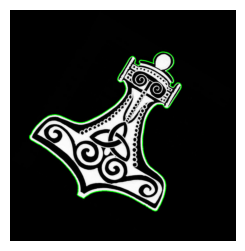

In [133]:
plot_img(img_boundary)

In [134]:
contours[0].shape

(1709, 1, 2)

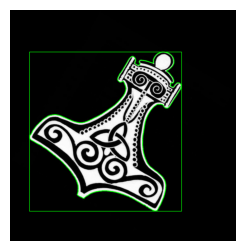

In [135]:
x,y,w,h = cv2.boundingRect(contours[0])
plot_img(cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2))

## Min Area Rect

In [136]:
rect = cv2.minAreaRect(contours[0])
rect
# (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(points)

((512.043701171875, 619.901123046875),
 (779.97900390625, 871.3473510742188),
 8.646007537841797)

In [138]:
box = cv2.boxPoints(rect)
box

array([[  60.991516,  991.99695 ],
       [ 191.98053 ,  130.5516  ],
       [ 963.0959  ,  247.8053  ],
       [ 832.1069  , 1109.2506  ]], dtype=float32)

In [143]:
# platform specify
box = np.intp(box)
box

array([[  60,  991],
       [ 191,  130],
       [ 963,  247],
       [ 832, 1109]], dtype=int64)

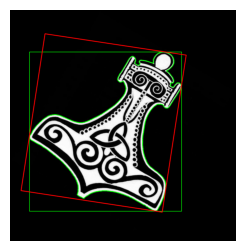

In [144]:
plot_img(cv2.drawContours(img,[box],-1,(0,0,255),3))

## min Enclosing circle

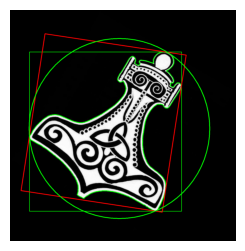

In [147]:
center ,radius = cv2.minEnclosingCircle(contours[0])
center = [int(c) for c in center]
radius = int(radius)
plot_img(cv2.circle(img,center,radius,(0,255,0),3))

## All together

In [69]:
def image_boundary_detection(img_path,
                             min_area = 100.,
                             bbox=True,
                             min_bbox=True,
                             min_encircle=True):
    # read the image 
    img = cv2.imread(img_path)
    
    # convert the image into gray scale 
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # thresh hold the image
    _ , thresh = cv2.threshold(src=gray_img,
                               thresh=127,
                               maxval=255,
                               type=cv2.THRESH_BINARY)
    
    # find the contours
    contours , hierarchy = cv2.findContours(image=thresh,
                                            mode=cv2.RETR_EXTERNAL,
                                            method=cv2.CHAIN_APPROX_SIMPLE)
    
    # draw the different boundary
    print(f"total contours {len(contours)} , {contours[0].shape}")
    for c in contours:        
        # draw the bounding box (rectangle)
        if bbox:
            x,y,w,h = cv2.boundingRect(c)
            if w*h >= min_area:
                cv2.rectangle(img=img,
                            # both pt1 and pt1 are opposite corner
                            pt1=(x,y),
                            pt2=(x+w,y+h),
                            color=(0,255,0),
                            thickness=3
                            )
            
        # draw the min bounding area
        if min_bbox:
            # get center(x,y),(w,h),angle of rotation
            rect = cv2.minAreaRect(c)
            if rect[1][0] * rect[1][1] >= min_area:            
                # convert them four corners
                box = cv2.boxPoints(rect)
                
                # convert them integer
                box = np.intp(box)
                # draw the contour
                cv2.drawContours(image=img,
                                contours=[box],
                                contourIdx=0,
                                color=(0,0,255),
                                thickness=3
                                )
        
        # draw the min enclosing circle
        if min_encircle:
            center , radius = cv2.minEnclosingCircle(c)
            # covert them int
            center  = [int(p) for p in center]
            radius = int(radius)
            # draw circle 
            img = cv2.circle(img=img,
                            center=center,
                            radius=radius,
                            color=(0,255,0),
                            thickness=3
                            )
    plot_img(img) 

total contours 1 , (1709, 1, 2)


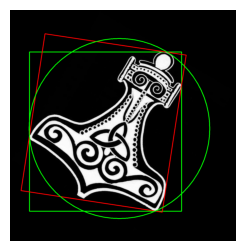

In [70]:
image_boundary_detection("../images/hammer.jpg")

In [71]:
response = requests.get("https://e1.pxfuel.com/desktop-wallpaper/539/453/desktop-wallpaper-new-york-roaming-crossing-road.jpg",
                        stream=True)
if response.status_code == 200:
    with open("../images/traffic.jpg",'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)

total contours 1849 , (1, 1, 2)


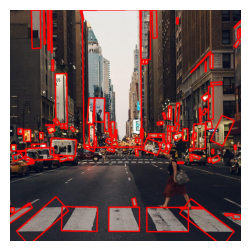

In [72]:
image_boundary_detection("../images/traffic.jpg",min_encircle=False,min_bbox=True,min_area=100,bbox=False)

In [73]:
response = requests.get("https://media.istockphoto.com/id/1011441936/photo/traffic-jam-on-multilane-road.jpg?b=1&s=612x612&w=0&k=20&c=vGbe1-NigiE71IGsoQ4RbD0CSwVr2gwbxykKr9sZMLE=",
                        stream=True)
if response.status_code == 200:
    with open("../images/traffic1.jpg",'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)

total contours 264 , (2, 1, 2)


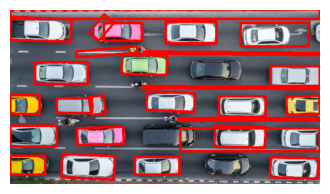

In [75]:
image_boundary_detection("../images/traffic1.jpg",min_encircle=False,min_bbox=True,min_area=1000,bbox=False)

## Convex Contour

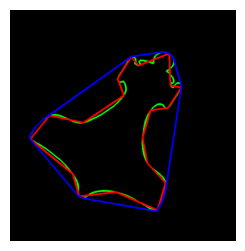

In [80]:
# read the image
img = cv2.pyrDown(cv2.imread("../images/hammer.jpg",cv2.IMREAD_UNCHANGED))

# convert gray image
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# set the threshold
_,thresh  = cv2.threshold(src=gray_img,
                          thresh=127,
                          maxval=255,
                          type=cv2.THRESH_BINARY)

# find the contours
contours ,hierarchy = cv2.findContours(image=thresh,
                                       mode=cv2.RETR_EXTERNAL,
                                       method=cv2.CHAIN_APPROX_SIMPLE)

black = np.zeros_like(img)
for cnt in contours:
    # maximum difference btw approx and original
    epsilon = 0.01 * cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    hull = cv2.convexHull(cnt)
    
    
    cv2.drawContours(black,
                     contours=[cnt],
                     contourIdx=-1,
                     color=(0,255,0),thickness=3)
    cv2.drawContours(black,
                     contours=[approx],
                     contourIdx=-1,
                     color=(0,0,255),thickness=3)
    cv2.drawContours(black,
                     contours=[hull],
                     contourIdx=-1,
                     color=(255,0,0),thickness=3)
plot_img(black)

This works well on simple images, in which we have only one or a few objects, and only a few colors that are easily separated by thresholds. Unfortunately, color thresholding and contour detection are less effective on complex images that contain several objects or multicolored objects

## Detecting lines

1. Detecting line and shape detection has its foundation in a technique called **Hough transformers.**.
2. OpenCV provide two function 
   1. HoughLines ----> return the single point and angle
   2. HoughLinesP (P - probability) --> return the two points start end end
3. HoughLinesP only analyze the subset of points and then estimate the prob of point that belong to same line. So HoughLineP is faster and less computational intensive.

[Refer HOUGH LINE](https://theailearner.com/2020/11/20/hough-line-transform/)


In [86]:
download_image("https://cdn2.veltra.com/ptr/20200408035938_105619108_2445_0.jpg","lines")

[INFO] downloading image and saving to ../images/lines.jpg


In [77]:
def detect_lines(filepath):
    # read the image
    img = cv2.imread(filepath)
    # convert to gray image
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find the edge using Canny
    edges = cv2.Canny(image=gray_img,threshold1=100,threshold2=200)
    plot_img(edges)
    min_line_length , min_line_gap = 5,5

    # use the hough line P
    lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180.0,threshold=20,lines=20,
                minLineLength=min_line_length,
                    maxLineGap=min_line_gap)

    black = np.zeros_like(img)
    for x1,y1,x2,y2 in lines.squeeze():
        cv2.line(black,(x1,x2),(x2,y2),
                color=(0,255,0),thickness=2)

    plot_img(black)
    plot_img(img)

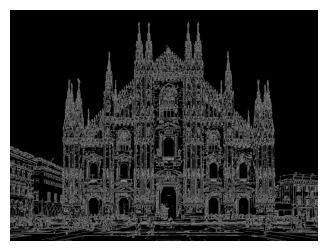

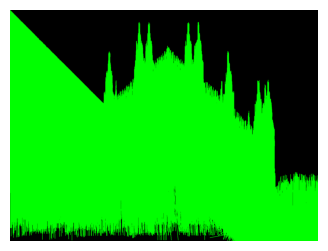

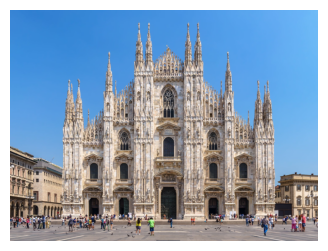

In [78]:
detect_lines("../images/lines.jpg")